# Individual Assignment - Week 4

## Individual Assignment - Pandas, Numpy, Sentiment Analysis

### Joshua Dollison
### CIS591-86718
### 9/23/2025

### Read Sales Data

Create a data frame to store the data read from the file.

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

# Read the data from a csv
#   the sales #'s have commas and are treated like strings
#   i pass in the thousands arg to convert them to ints
df = pd.read_csv('IA 4_LastYearSales.csv', thousands=",")

# Rename columns for easier use
df = df.rename(columns={
    "Month": "month",
    "Temperature (°F)": "temp_f",
    "GreenTote": "green_tote",
    "SolarTrek Water Bottle": "solar_trek_water_bottle"
})

# print out the data
print(df.tail())
print(df.dtypes)

        month  temp_f  green_tote  solar_trek_water_bottle
7      August      88      185800                   130500
8   September      86      180900                   128800
9     October      80      170000                   120000
10   November      70      165000                   114000
11   December      60      160000                   110000
month                      object
temp_f                      int64
green_tote                  int64
solar_trek_water_bottle     int64
dtype: object


### 1 - Set EcoSmart Sales Target

- If the temperature is above 65°F, set the sales target to be 5% higher than the average sales of months with similar temperatures
- If the temperature is between 60°F and 65°F, set the sales target to be equal to the average sales of similar months
- If the temperature is below 60°F, set the sales target to be 10% lower than the average sales of similar months

In [2]:
# create a function to assign the new targets
def calc_target(data, filter, perc) :

    # use the filter to calculate the average of the green_tote
    avg = data[filter]['green_tote'].mean()

    # set the target to that avg + the percentage multiplier
    #    i use the math.ceil b/c these are discrete objects - there
    #    can't be .2334121... of a backpack - so round up
    data.loc[filter, 'ecosmart_target'] = math.ceil(avg + (avg * perc))

# set target for temps above 65
calc_target(df, (df["temp_f"] > 65), .05)

# set target for temps between 60 and 65
calc_target(df, (df["temp_f"].between(60, 65)), 0)

# set target for temps below 60
calc_target(df, (df["temp_f"] < 60), (-.1))

# i want this value to be an integer
df['ecosmart_target'] = df['ecosmart_target'].astype(int)

# print out the new targets
df

,month,temp_f,green_tote,solar_trek_water_bottle,ecosmart_target
0,January,40,87500,80900,91155
1,February,45,100625,85200,91155
2,March,55,115725,92500,91155
3,April,65,132075,100980,146038
4,May,75,148875,110500,178170
5,June,85,164500,118300,178170
6,July,90,172725,124800,178170
7,August,88,185800,130500,178170
8,September,86,180900,128800,178170
9,October,80,170000,120000,178170


### Read Sentiment Data

Read the customer reviews file.

In [3]:
# Read the data from a csv
df_sent = pd.read_csv('Tote_Bag_Reviews_with_Ratings.csv')


# Rename columns for easier use
#  The assignment has us write our own sentiment value,
#     so I call the existing value gpt_sentiment to keep it
df_sent.rename(columns={
    "Review": "review",
    "Rating": "rating",
    "Sentiment": "gpt_sentiment"
}, inplace=True)


# print out the data
print(df_sent.tail())

                                                review gpt_sentiment  rating
495  I appreciate the sustainable materials used; v...      Positive       5
496  The eco-friendly claim seems questionable; no ...      Negative       1
497  The eco-friendly claim seems questionable; no ...      Negative       1
498  The eco-friendly claim seems questionable; no ...      Negative       1
499  Great for carrying all my gear without feeling...      Positive       5


### Build Core Sentiment Analysis Functionality

Import the libraries required and build a custom function that allows me to score text and assign a label given a score.

In [4]:
# Create a SentimentIntensityAnalyzer object.
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj = SentimentIntensityAnalyzer()

# Using the polarity score interpretation from the in-class assignment
def get_sentiment_text(sentence) :
    
    # get the score
    c_score = sid_obj.polarity_scores(sentence)['compound']

    # assign the score a label
    sentiment_text = 'unknown'
    if c_score >= 0.05:
        sentiment_text = 'positive'
    elif c_score <= -0.05:
        sentiment_text = 'negative'
    else:
        sentiment_text = 'neutral'

    # return the score and the label
    return c_score, sentiment_text

### 2 - Perform Sentiment Analysis

Write Python code to label each review as positive, neutral, or negative based on its compound score with SentimentIntensityAnalyzer and add a new column to the data frame calling it "sentiment".

In [5]:
# Apply get_sentiment_text(review) to each review.  Write the two return values
#    of the custom function to the 'score' and 'sentiment' columns.
#    Score wasn't required, but I saved it for future analysis
df_sent[['score', 'sentiment']] = df_sent['review'].apply(lambda review: pd.Series(get_sentiment_text(review)))

# output the updated dataframe
df_sent

,review,gpt_sentiment,rating,score,sentiment
0,I expected better quality for the price; not w...,Negative,1,0.3036,positive
1,It cleans easily after outdoor adventures; a b...,Positive,5,0.5859,positive
2,Handles are uncomfortable and dig into my hands.,Negative,1,-0.3818,negative
3,Lightweight and easy to carry during hikes and...,Positive,5,0.4404,positive
4,The handles are sturdy and comfortable to hold.,Positive,5,0.5106,positive
...,...,...,...,...,...
495,I appreciate the sustainable materials used; v...,Positive,5,0.6801,positive
496,The eco-friendly claim seems questionable; no ...,Negative,1,-0.5267,negative
497,The eco-friendly claim seems questionable; no ...,Negative,1,-0.5267,negative
498,The eco-friendly claim seems questionable; no ...,Negative,1,-0.5267,negative


### 3 - Avg Rating by Sentiment Value

Calculate the average rating of the reviews for each review category (i.e., positive, neutral, and negative)

In [6]:
# for each sentiment value, calc the mean
df_sent.groupby('sentiment')['rating'].mean()

sentiment
negative    1.000000
neutral     1.651852
positive    4.692308
Name: rating, dtype: float64

### 4 - Sentiment Value Counts

Calculate the total number of positive, neutral, and negative reviews.

I also included % of total to see ratios of each.

In [7]:
# i want to add a distribution field, so i reshape beyond the group by for counts
#   axis is renamed for fomratting
#   counts get are set to be the 'count' field
sent_counts = (
    df_sent['sentiment']
    .value_counts()
    .rename_axis('sentiment')
    .reset_index(name='count')
)

# use the counts to calc dist
sent_counts['pct'] = (sent_counts['count'] / len(df_sent) * 100).round(2)

# output counts and dist
sent_counts

,sentiment,count,pct
0,positive,247,49.4
1,neutral,135,27.0
2,negative,118,23.6


### Save To CSV

Write your data frame that has the sentiment column to a csv file called "YourLastName_YourFirstName_sentiment.csv"

In [8]:
df_sent.to_csv('DOLLISON_JOSHUA_sentiment.csv')

### Other analysis

In [9]:
# avg score by sentiment
df_sent.groupby('sentiment')['score'].mean()

sentiment
negative   -0.419876
neutral     0.000000
positive    0.554386
Name: score, dtype: float64

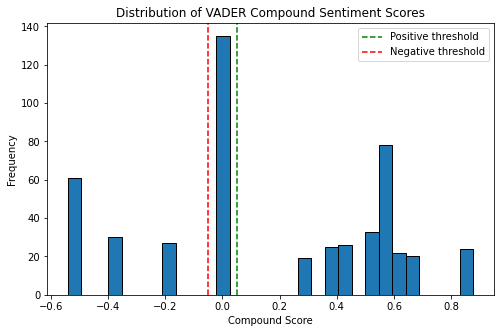

In [10]:
# chart the dist of our score
plt.figure(figsize=(8,5))
plt.hist(df_sent["score"], bins=30, edgecolor="black")
plt.title("Distribution of VADER Compound Sentiment Scores")
plt.xlabel("Compound Score")
plt.ylabel("Frequency")
plt.axvline(0.05, color="green", linestyle="--", label="Positive threshold")
plt.axvline(-0.05, color="red", linestyle="--", label="Negative threshold")
plt.legend()
plt.show()

In [11]:
# print the bins and frequency values that were charted above
scores = pd.to_numeric(df_sent["score"], errors="coerce").dropna()
counts, bins = np.histogram(scores, bins=30)
hist_table = pd.DataFrame({"bin_start": bins[:-1], "bin_end": bins[1:], "count": counts})
hist_table = hist_table[hist_table["count"] > 0].reset_index(drop=True)

hist_table

,bin_start,bin_end,count
0,-0.5413,-0.4940,61
1,-0.3994,-0.3521,30
2,-0.2102,-0.1629,27
3,-0.0210,0.0263,135
4,0.2628,0.3101,19
5,0.3574,0.4047,25
6,0.4047,0.4520,26
7,0.4993,0.5466,33
8,0.5466,0.5939,78
9,0.5939,0.6412,22


In [12]:
# ratings counts/distribution

rating_counts = (
    df_sent["rating"].value_counts()
    .sort_index()
    .rename_axis("rating")
    .reset_index(name="count")
)

rating_counts["pct"] = (rating_counts["count"] / len(df_sent) * 100).round(2)

rating_counts

,rating,count,pct
0,1,250,50.0
1,5,250,50.0


In [13]:
# distributions of ratings by sentiment

counts = df_sent.groupby(["sentiment","rating"]).size().unstack(fill_value=0).reindex(columns=[1,2,3,4,5], fill_value=0)
pct = (counts.div(counts.sum(axis=1), axis=0)*100).round(1)
pct.columns = [f"{c}_pct" for c in pct.columns]
dist = pd.concat([counts, pct], axis=1)
dist

,1,2,3,4,5,1_pct,2_pct,3_pct,4_pct,5_pct
sentiment,,,,,,,,,,
negative,118,0,0,0,0,100.0,0.0,0.0,0.0,0.0
neutral,113,0,0,0,22,83.7,0.0,0.0,0.0,16.3
positive,19,0,0,0,228,7.7,0.0,0.0,0.0,92.3


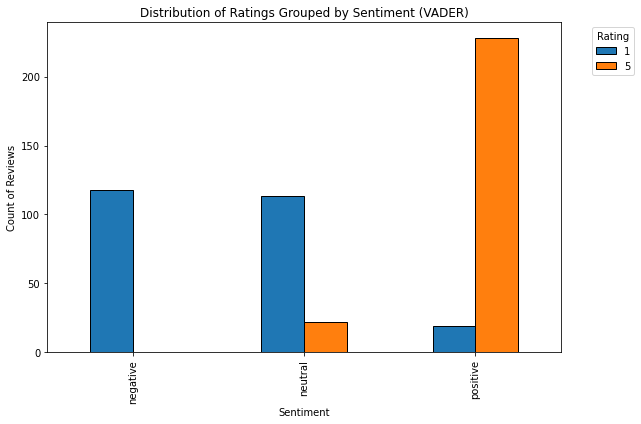

In [14]:
# Grouped counts: sentiment vs rating
grouped = df_sent.groupby(["sentiment", "rating"]).size().unstack(fill_value=0)

# Plot grouped bar chart
grouped.plot(kind="bar", figsize=(9,6), edgecolor="black")
plt.title("Distribution of Ratings Grouped by Sentiment (VADER)")
plt.xlabel("Sentiment")
plt.ylabel("Count of Reviews")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### Summary

- Sentiment Value Counts
    - <b>49.4%</b> of reviews were scored <b>positive</b>
    - <b>27.0%</b> of reviews were scored <b>neutral</b>
    - <b>23.6%</b> of reviews were scored <b>negative</b>
<br/><br/>
- Ratings
    - Ratings were binary - 1 or 5, nothing in between
<br/><br/>
- Ratings by Sentiment Value
    - <b>100%</b> of people who were assigned a <b>'negative'</b> label gave a <b>negative</b> (1) rating
    - <b>~84%</b> of people who were assigned a <b>'neutral'</b> label gave a <b>negative</b> (1) rating
    - <b>~8%</b> of people who were assigned a <b>'positive'</b> label gave a <b>negative</b> (1) rating
<br/><br/>
- Score Distribution
  - <b>100%</b> of people who were assigned a <b>'neutral'</b> label received a compound score of 0.
  - People who were labeled <b>'negative'</b> primarily clustered around 3 bins, with the majority. <b>~52%</b>, skewed toward the most negative scores.
  - People who were labeled <b>'positive'</b> showed a much more normal distribution pattern across a greater variety of bins.
<br/><br/>

Overall, I tend to be a little suspicious of the accuracy of our chosen scoring model - particularly those labeled as neutral.  The ratings seem to be remarkably lower than one would expect for a neutral statement.  It could also be a data quality issue, as the binary selections of rating values, 1 or 5, don't seem to allow representations of neutrality in this selection (one would expect to see averages closer to maybe 2.5).

I would recommend comparing our results to other scoring algorithms to see how dissimilar the patterns looked before investing too heavily in any decision made from these scores.

If the data and the selected model hold, I would still say that the customers weren't necessarily thrilled with the product.  Less than half offered positive remarks and of the slightly greater than 25% that gave a neutral review, they still rated the product very low.  Finally, most of the people who left a negative review, REALLY seemed to dislike it.

I would want to verify our numbers with review performance of historic products though - probably GreenTote as we used that as a basis for sales targets.  Perhaps people just don't have a lot of positive things to say and 49% positive is good enough to generate sales comparable to GreenTote.

### BONUS Analysis

In [15]:
# for each sentiment value, calc the mean
df_sent.groupby('gpt_sentiment')['rating'].mean()

gpt_sentiment
Negative    1.0
Positive    5.0
Name: rating, dtype: float64

In [16]:
# i want to add a distribution field, so i reshape beyond the group by for counts
#   axis is renamed for fomratting
#   counts get are set to be the 'count' field
sent_counts = (
    df_sent['gpt_sentiment']
    .value_counts()
    .rename_axis('gpt_sentiment')
    .reset_index(name='count')
)

# use the counts to calc dist
sent_counts['pct'] = (sent_counts['count'] / len(df_sent) * 100).round(2)

# output counts and dist
sent_counts

,gpt_sentiment,count,pct
0,Negative,250,50.0
1,Positive,250,50.0


In [17]:
# Group by GPT sentiment and VADER sentiment
gpt_sent_v_sent = df_sent.groupby(["gpt_sentiment", "sentiment"]).size().unstack(fill_value=0)
gpt_sent_v_sent

sentiment,negative,neutral,positive
gpt_sentiment,,,
Negative,118,113,19
Positive,0,22,228


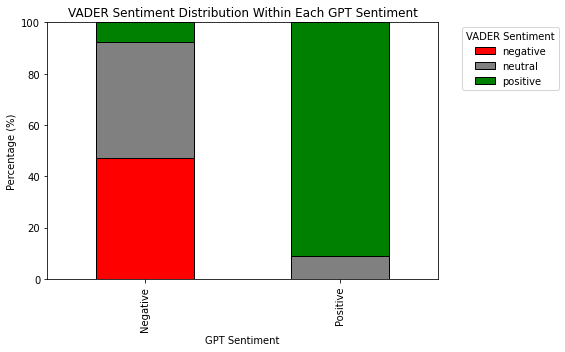

In [18]:
# Compute row-wise percentages
gpt_sent_v_sent_pct = gpt_sent_v_sent.div(gpt_sent_v_sent.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
gpt_sent_v_sent_pct.plot(
    kind="bar", stacked=True, figsize=(8,5),
    color=["red", "gray", "green"], edgecolor="black"
)

plt.title("VADER Sentiment Distribution Within Each GPT Sentiment")
plt.ylabel("Percentage (%)")
plt.xlabel("GPT Sentiment")
plt.legend(title="VADER Sentiment", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

### BONUS Assessment

It is obvious that either the GPT analysis simply labeled reviews with a rating of 1 as negative and a rating of 5 as positive <b>OR</b> someone added the binary ratings to the csv file after the labeling occurred.

There is no third neutral category, which might give us some understanding of 'tie-breaker' reviews that might lean a little more negative or positive.

This analysis loses any benefit to having the text review data.

Directly comparing the two, we see the same issues that I raised as potential flags in the earlier analysis:
- 8% of people marked positive in the compound score analyis gave a rating of 1 - so they were marked negative by GPT
- All of our people marked neutral in the compound score analysis were marked negative by GPT if they gave a rating of 1 or positive if they gave a rating of 5.

Out of curiosity, I asked GPT to offer additional ways of scoring the polarity within the remarks.

One of several models that it suggested was Afinn. We see below that while this model seems to have fewer misalignments between low rating and neutral, it skews more toward a positive label, with many more low ratings in that category.

If I were consulting this firm, I would spend much more time validating scores, reviewing data quality, and investigating strengths/weaknesses across models before making any significant recommendations to this client.

In [19]:
!pip install afinn

import pandas as pd
from afinn import Afinn

af = Afinn(emoticons=True)

def afinn_label(score, pos=1):
    return "positive" if score >= pos else ("negative" if score <= -pos else "neutral")

df_afinn = df_sent.copy(deep=True)

df_afinn["afinn_score"] = df_afinn["review"].fillna("").map(af.score)
df_afinn["afinn_sentiment"] = df_afinn["afinn_score"].map(afinn_label)

df_afinn

,review,gpt_sentiment,rating,score,sentiment,afinn_score,afinn_sentiment
0,I expected better quality for the price; not w...,Negative,1,0.3036,positive,6.0,positive
1,It cleans easily after outdoor adventures; a b...,Positive,5,0.5859,positive,3.0,positive
2,Handles are uncomfortable and dig into my hands.,Negative,1,-0.3818,negative,-2.0,negative
3,Lightweight and easy to carry during hikes and...,Positive,5,0.4404,positive,1.0,positive
4,The handles are sturdy and comfortable to hold.,Positive,5,0.5106,positive,2.0,positive
...,...,...,...,...,...,...,...
495,I appreciate the sustainable materials used; v...,Positive,5,0.6801,positive,6.0,positive
496,The eco-friendly claim seems questionable; no ...,Negative,1,-0.5267,negative,-1.0,negative
497,The eco-friendly claim seems questionable; no ...,Negative,1,-0.5267,negative,-1.0,negative
498,The eco-friendly claim seems questionable; no ...,Negative,1,-0.5267,negative,-1.0,negative


In [20]:
# --- GPT vs AFINN comparison ---
gpt_vs_afinn = pd.crosstab(df_afinn["gpt_sentiment"], df_afinn["afinn_sentiment"])

# --- VADER vs AFINN comparison ---
vader_vs_afinn = pd.crosstab(df_afinn["sentiment"], df_afinn["afinn_sentiment"])

print("GPT vs AFINN")
print(gpt_vs_afinn, "\n")

print("VADER vs AFINN")
print(vader_vs_afinn)

GPT vs AFINN
afinn_sentiment  negative  neutral  positive
gpt_sentiment                               
Negative               91       94        65
Positive                0        0       250 

VADER vs AFINN
afinn_sentiment  negative  neutral  positive
sentiment                                   
negative               91       27         0
neutral                 0       67        68
positive                0        0       247


In [21]:
df_afinn.groupby('afinn_sentiment')['rating'].mean()

afinn_sentiment
negative    1.000000
neutral     1.000000
positive    4.174603
Name: rating, dtype: float64

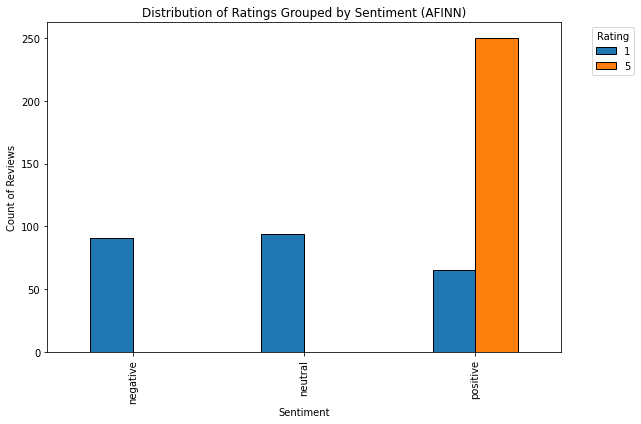

In [22]:
# Grouped counts: sentiment vs rating
grouped = df_afinn.groupby(["afinn_sentiment", "rating"]).size().unstack(fill_value=0)

# Plot grouped bar chart
grouped.plot(kind="bar", figsize=(9,6), edgecolor="black")
plt.title("Distribution of Ratings Grouped by Sentiment (AFINN)")
plt.xlabel("Sentiment")
plt.ylabel("Count of Reviews")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()